In [30]:
def get_snl(samples,zs,units='Mpch'):
    """
    samples: MCMC samples (getdist)
    zs: redshifts (np array)
    """
    from colossus.cosmology import cosmology

    # Extract relevant parameters for each sample
    omega_m = samples.samples[:, samples.index['omegam']]
    sigma_8 = samples.samples[:, samples.index['sigma8']]
    H0 = samples.samples[:, samples.index['H0']] # if 'H0' in samples.paramNames.names else 67.2  # Planck value
    omega_b = samples.samples[:, samples['omegab']] if 'omegab' in samples.paramNames.names else \
        samples.samples[:,samples.index['omegabh2']]/(H0/100)**2
    n_s = samples.samples[:, samples.index['ns']]  # Scalar spectral index

    # Set output arrays
    snl = np.zeros((len(zs),len(omega_m)))
    rnl = np.zeros((len(zs),len(omega_m)))
    D_V = np.zeros((len(zs),len(omega_m)))
    D_A = np.zeros((len(zs),len(omega_m)))
    D_M = np.zeros((len(zs),len(omega_m)))
    s12 = np.zeros((len(zs),len(omega_m)))

    for i in range(len(omega_m)):
        cosmo_params = {
            'Om0': omega_m[i],
            'sigma8': sigma_8[i],
            'H0': H0[i],
            'Ob0': omega_b[i],
            'ns': n_s[i]
        }

        # Set the cosmology for this set of parameters
        cosmo = cosmology.setCosmology('myCosmo', params=cosmology.cosmologies['planck18'], **cosmo_params)

        # Get r non-linear, angular distance D_A, comoving distance D_H
        if units=='Mpch':
            rnl[:,i]  = cosmo.sigma(1, z=zs, inverse=True)
            D_H = (cosmology.constants.C/100000)/(cosmo.Ez(zs)*100) #[Mpc/h]
            D_A[:,i] = cosmo.angularDiameterDistance(zs) #Angular diameter distance [Mpc/h]

        if units=='Mpc':
            rnl[:,i]  = cosmo.sigma(1, z=zs, inverse=True)/(H0[i]/100)
            D_H = (cosmology.constants.C/100000)/(cosmo.Ez(zs)*H0[i]) #[Mpc]
            D_A[:,i] = cosmo.angularDiameterDistance(zs)*100/H0[i] #Angular diameter distance [Mpc]

        # Get Dv
        D_M[:,i] = (1+zs)*D_A[:,i]
        D_V[:,i] = (D_H*zs*D_M[:,i]**2)**(1./3) #Volume-averaged distance

        # Get sigma_12
        s12[:,i]  = cosmo.sigma(12*(H0[i]/100.), z=zs, inverse=False)


        # Get s non-linear
        snl[:,i] = rnl[:,i]/D_V[:,i]

    return snl, rnl, D_V, s12, D_A, D_M


import numpy as np 
from getdist import loadMCSamples
import matplotlib.pyplot as plt

units = 'Mpc'

chain_root_cmb = '../data/CosmoParams/base/plikHM_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE'
chain_root_des = '../data/CosmoParams/base/DES_DESpriors/base_DES_DESpriors'

samples_cmb = loadMCSamples(chain_root_cmb)
samples_des = loadMCSamples(chain_root_des)

zs = np.array([0.1])

snl_cmb, rnl_cmb, Dv_cmb, s12_cmb, DA_cmb, DM_cmb = get_snl(samples_cmb,zs,units)
snl_des, rnl_des, Dv_des, s12_des, DA_des, DM_des = get_snl(samples_des,zs,units)

# Calculate wm = Om h^2
# CMB
omegamh2_cmb = samples_cmb.samples[:, samples_cmb.index['omegamh2']]
# DES
omegamh2_des = samples_des.samples[:, samples_des.index['omegamh2']] if 'omegamh2' in \
    samples_des.paramNames.names else \
        samples_des.samples[:, samples_des.index['omegam']]*(samples_des.samples[:, samples_des.index['H0']]/100)**2


In [31]:
snl_cmb[0]

array([0.01887522, 0.01837896, 0.01831497, ..., 0.01806606, 0.01821215,
       0.01856201])

In [32]:
samples_cmb.addDerived(snl_cmb[0], name='s_nl', label=r's_{NL}')
samples_cmb.addDerived(rnl_cmb[0], name='r_nl', label=r'r_{NL}')
samples_cmb.addDerived(s12_cmb[0], name='sigma12', label=r'\sigma_{12}')
#samples_cmb.addDerived(omegamh2_cmb, name='omegamh2', label=r'\Omega_m h^2')

samples_des.addDerived(rnl_des[0], name='r_nl', label=r'r_{NL}')
samples_des.addDerived(snl_des[0], name='s_nl', label=r's_{NL}')
samples_des.addDerived(s12_des[0], name='sigma12', label=r'\sigma_{12}')
samples_des.addDerived(omegamh2_des, name='omegamh2', label=r'\Omega_m h^2')

[0.00366907]


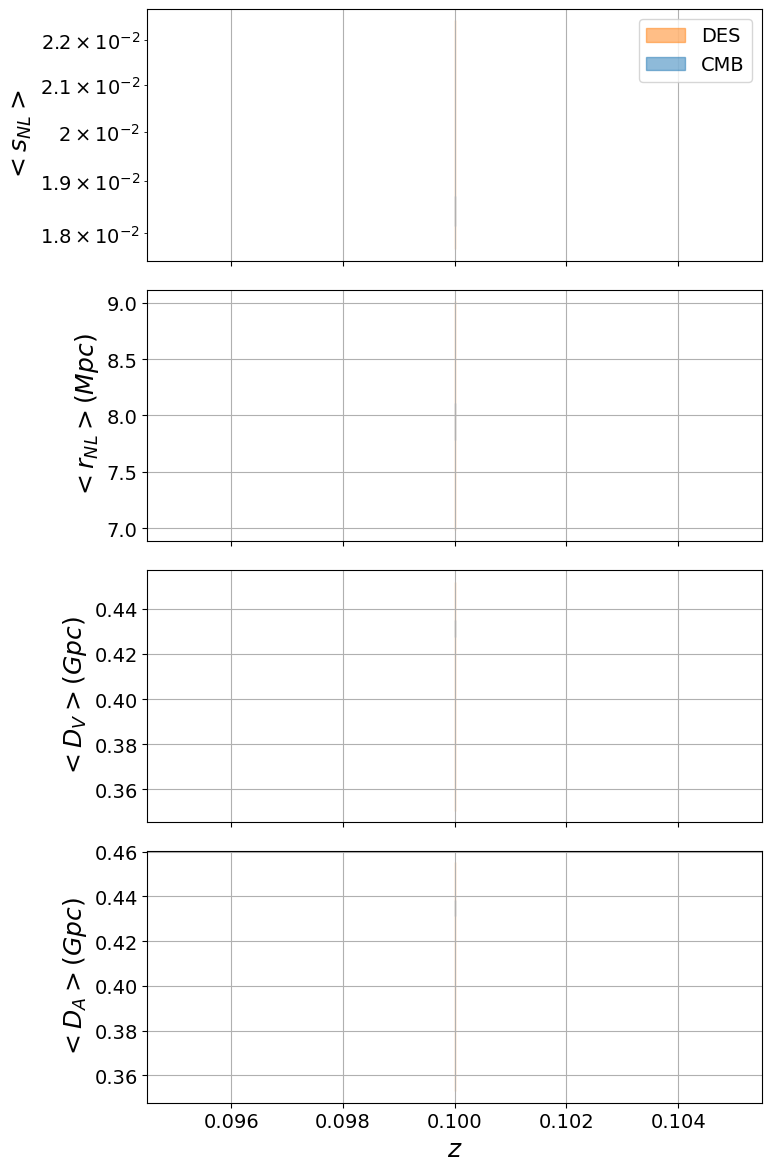

In [33]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16, 'axes.labelsize': 18, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14})

fig, axs = plt.subplots(4, 1, figsize=(8, 12),sharex=True)

# Optional: Add a title and axis labels
#plt.title("r and s non linear vs redshift")
axs[0].set_ylabel(r"$<s_{NL}>$")
axs[1].set_ylabel(r"$<r_{NL}> (Mpc h^{-1})$" if 'h' in units else r"$<r_{NL}> (Mpc)$")
axs[2].set_ylabel(r"$<D_V> (Gpc h^{-1})$" if 'h' in units else r"$<D_V> (Gpc)$")
axs[3].set_ylabel(r"$<D_A> (Gpc h^{-1})$" if 'h' in units else r"$<D_A> (Gpc)$")

axs[-1].set_xlabel(r"$z$")

# Plot data with optional formatting (line style, color, marker, etc.)
snl_cmb_mean = np.mean(snl_cmb,axis=1)
snl_des_mean = np.mean(snl_des,axis=1)
snl_cmb_std = np.std(snl_cmb,axis=1,ddof=1)
snl_des_std = np.std(snl_des,axis=1,ddof=1)

Dv_cmb_mean = np.mean(Dv_cmb/1000.,axis=1)
Dv_des_mean = np.mean(Dv_des/1000.,axis=1)
Dv_cmb_std = np.std(Dv_cmb/1000.,axis=1,ddof=1)
Dv_des_std = np.std(Dv_des/1000.,axis=1,ddof=1)

DM_cmb_mean = np.mean(DM_cmb/1000.,axis=1)
DM_des_mean = np.mean(DM_des/1000.,axis=1)
DM_cmb_std = np.std(DM_cmb/1000.,axis=1,ddof=1)
DM_des_std = np.std(DM_des/1000.,axis=1,ddof=1)

rnl_cmb_mean = np.mean(rnl_cmb,axis=1)
rnl_des_mean = np.mean(rnl_des,axis=1)
rnl_cmb_std = np.std(rnl_cmb,axis=1,ddof=1)
rnl_des_std = np.std(rnl_des,axis=1,ddof=1)

axs[0].fill_between(zs, snl_des_mean-snl_des_std, snl_des_mean+snl_des_std, label='DES', \
             linestyle='-', color='C01', alpha=.5)
axs[0].fill_between(zs, snl_cmb_mean-snl_cmb_std, snl_cmb_mean+snl_cmb_std, label='CMB', \
             linestyle='-', color='C00', alpha=.5)
axs[0].plot(zs, snl_des_mean, linestyle='--', color='C01')
axs[0].plot(zs, snl_cmb_mean, linestyle='--', color='C00')


axs[1].fill_between(zs, rnl_des_mean-rnl_des_std, rnl_des_mean+rnl_des_std,\
             linestyle='-', color='C01', alpha=.5)
axs[1].fill_between(zs, rnl_cmb_mean-rnl_cmb_std, rnl_cmb_mean+rnl_cmb_std,\
             linestyle='-', color='C00', alpha=.5)
axs[1].plot(zs, rnl_des_mean, linestyle='--', color='C01')
axs[1].plot(zs, rnl_cmb_mean, linestyle='--', color='C00')


axs[2].fill_between(zs, Dv_des_mean-Dv_des_std, Dv_des_mean+Dv_des_std,\
             linestyle='-', color='C01', alpha=.5)
axs[2].fill_between(zs, Dv_cmb_mean-Dv_cmb_std, Dv_cmb_mean+Dv_cmb_std,\
             linestyle='-', color='C00', alpha=.5)
axs[2].plot(zs, Dv_des_mean, linestyle='--', color='C01')
axs[2].plot(zs, Dv_cmb_mean, linestyle='--', color='C00')

axs[3].fill_between(zs, DM_des_mean-DM_des_std, DM_des_mean+DM_des_std,\
             linestyle='-', color='C01', alpha=.5)
axs[3].fill_between(zs, DM_cmb_mean-DM_cmb_std, DM_cmb_mean+DM_cmb_std,\
             linestyle='-', color='C00', alpha=.5)
axs[3].plot(zs, DM_des_mean, linestyle='--', color='C01')
axs[3].plot(zs, DM_cmb_mean, linestyle='--', color='C00')

axs[0].legend()
for ax in axs:
    ax.grid(True)


axs[0].set_yscale('log')
plt.tight_layout()
print(DM_cmb_mean-Dv_cmb_mean)
plt.show()


# plt.savefig("plot.png")


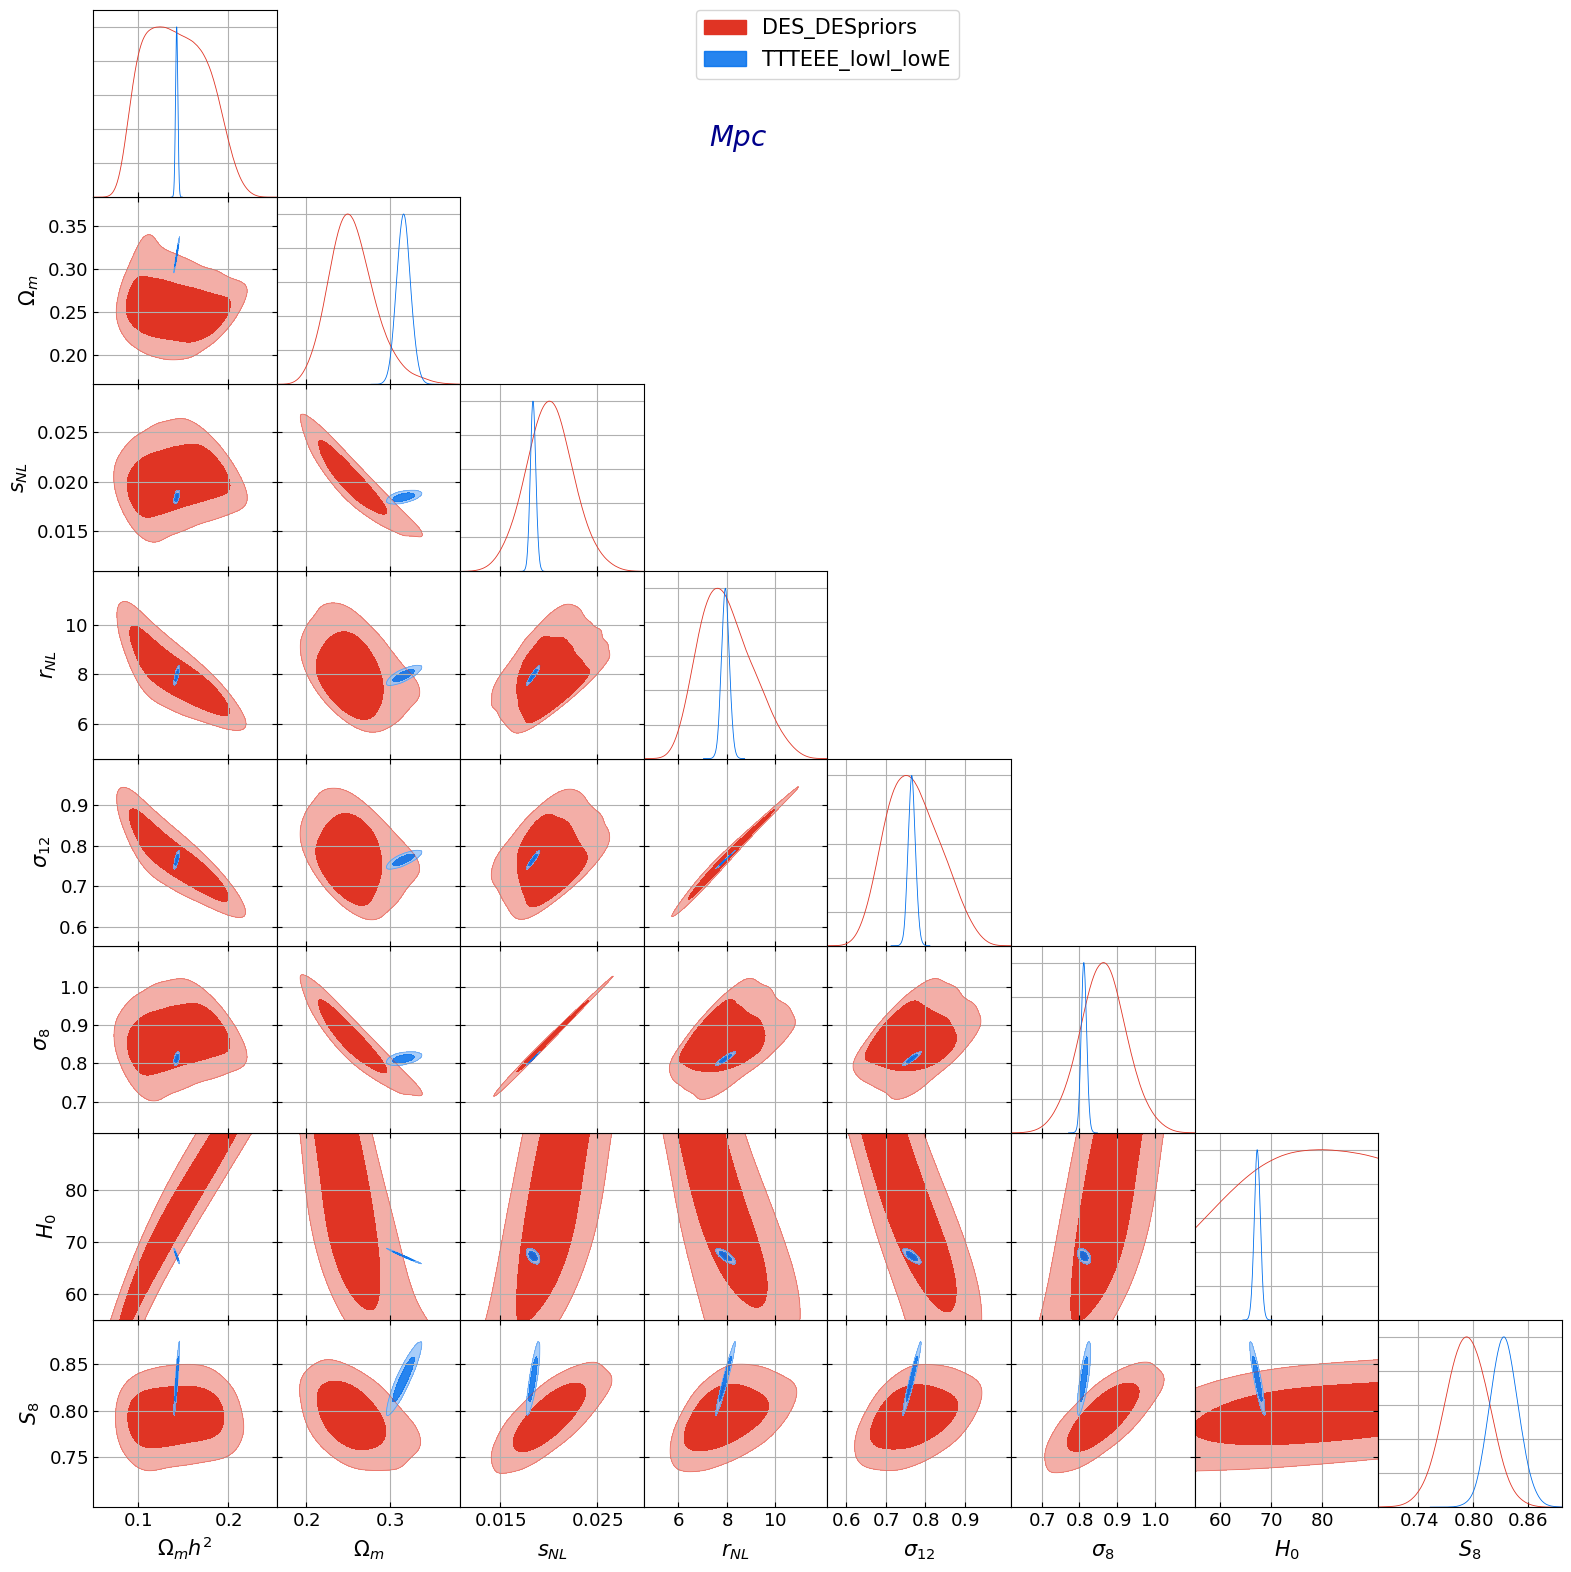

In [35]:
import matplotlib.pyplot as plt
from getdist import loadMCSamples, plots

colors =  plt.rcParams['axes.prop_cycle'].by_key()['color']
# Create a GetDist plotter
g = plots.get_subplot_plotter()

# Settings
g.settings.lab_fontsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 18

# Plot labels
labels = ['DES_DESpriors','TTTEEE_lowl_lowE']

# Generate the 2D plot with contours for Omega_m vs sigma_8
g.triangle_plot([samples_des,samples_cmb],params=['omegamh2','omegam','s_nl','r_nl','sigma12', 'sigma8','H0','S8'],\
                 filled=True, legend_labels=labels, grid=True)

g.fig.text(0.47, 0.9, r'$Mpc h^{-1}$' if 'h' in units else r'$Mpc$', ha='center', fontsize=20, color='darkblue')

# Enable the grid on each subplot, only if the axis is not None
for ax in g.subplots.flat:  # Flatten subplots to loop over all
    if ax:  # Check if ax is not None
        ax.grid(True)

# Show the plot
plt.show()  